--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


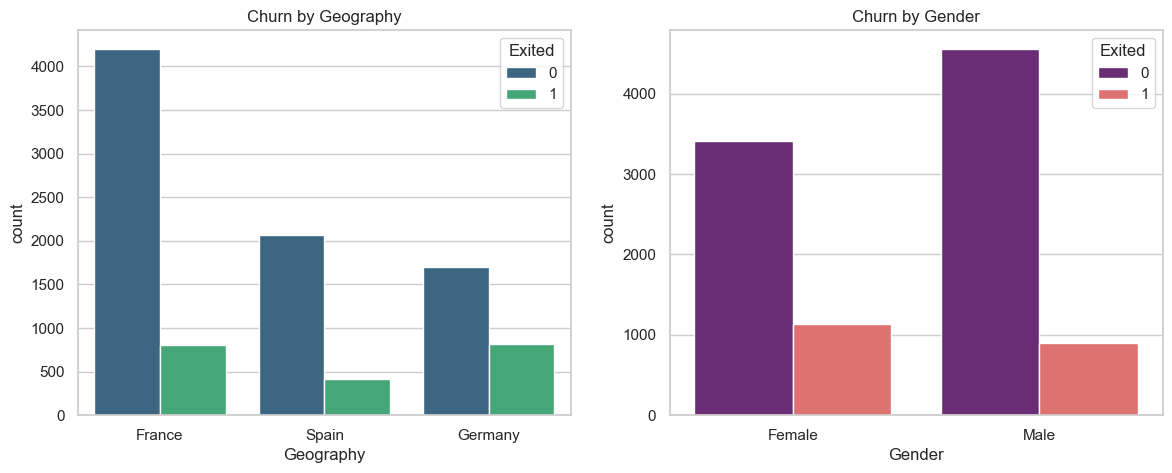

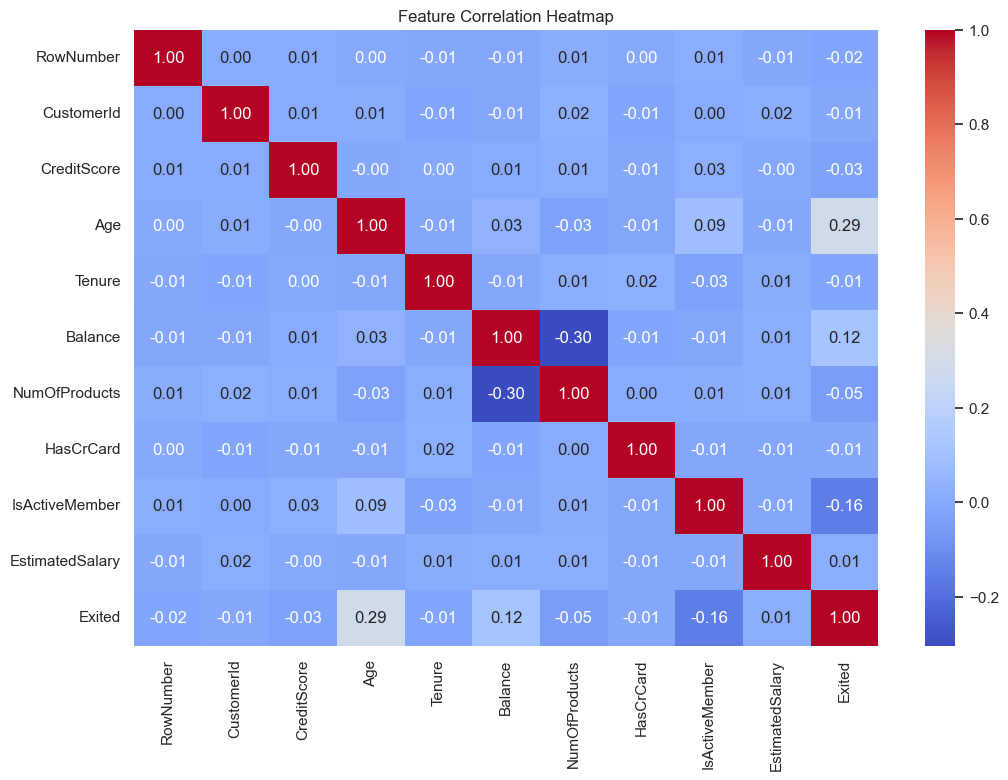


Model: Logistic Regression
Accuracy: 0.8080
ROC AUC: 0.7748
------------------------------
              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89      1593
         1.0       0.59      0.19      0.28       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000


Model: Random Forest
Accuracy: 0.8630
ROC AUC: 0.8511
------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92      1593
         1.0       0.78      0.46      0.58       407

    accuracy                           0.86      2000
   macro avg       0.83      0.71      0.75      2000
weighted avg       0.85      0.86      0.85      2000


Model: Gradient Boosting
Accuracy: 0.8700
ROC AUC: 0.8708
------------------------------
              precision    recall  f1-score   support

         0.0       0.88

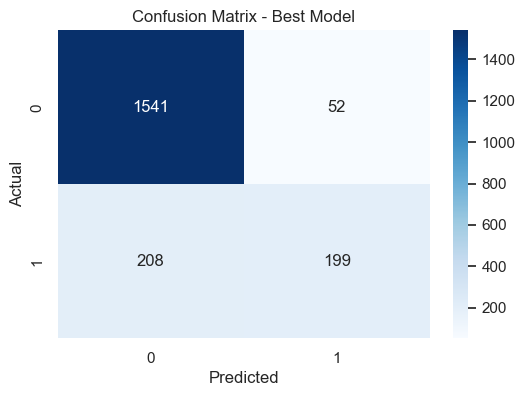


Model and Scaler saved successfully!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
import joblib  

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


data = pd.read_csv("Churn_Modelling.csv")


def perform_eda(df):
    print("--- Dataset Info ---")
    print(df.info())
    
    # Plot Churn by Geography and Gender
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    sns.countplot(x='Geography', hue='Exited', data=df, ax=ax[0], palette='viridis')
    ax[0].set_title('Churn by Geography')
    
    sns.countplot(x='Gender', hue='Exited', data=df, ax=ax[1], palette='magma')
    ax[1].set_title('Churn by Gender')
    plt.show()

   
    plt.figure(figsize=(12, 8))
    # Filter only numeric columns for correlation
    numeric_df = df.select_dtypes(include=[np.number])
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Heatmap')
    plt.show()

perform_eda(data)


data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)


data = pd.get_dummies(data, drop_first=True)
data = data.astype(float) # Better for scaling


X = data.drop('Exited', axis=1)
y = data['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

best_acc = 0
best_model = None

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"\n{'='*30}")
    print(f"Model: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1]):.4f}")
    print("-" * 30)
    print(classification_report(y_test, y_pred))
    
    
    if acc > best_acc:
        best_acc = acc
        best_model = model


cm = confusion_matrix(y_test, best_model.predict(X_test_scaled))
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best Model')
plt.show()


joblib.dump(best_model, 'best_churn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\nModel and Scaler saved successfully!")